# Credit Card Fraud

Quels facteurs sur les transactions bancaires nous permettent de prédire une fraude à la carte bancaire ?

- EDA
- Preprocessing (ACP, feature selection)
- Modèles :
-* ML supervisé de classification binaire avec régression logistique, RandomForest, (régression linéaire pour les montants) ;
-* ML non supervisé avec clustering géographique DBScan Elbow+Silhouette
- Confrontation des résultats (quel serait le meilleur modèle pour prédire la fraude)
- Exemple de prédiction
- Mise en place du dashboard
- Proposer des questions d'ouverture (pour la présentation)

Si on a le temps : prédire le montant de la fraude (régression linéaire)

1. Import usual libraries

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE, SMOTENC

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
#pio.renderers.default = "svg" # to be replaced by "iframe" if working on JULIE

In [2]:
data = pd.read_csv('src/fraud test.csv')
data.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,21/06/2020 12:14,2.291160e+15,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,19/03/1968,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,21/06/2020 12:14,3.573030e+15,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",17/01/1990,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,21/06/2020 12:14,3.598220e+15,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",21/10/1970,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,21/06/2020 12:15,3.591920e+15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,25/07/1987,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,21/06/2020 12:15,3.526830e+15,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,06/07/1955,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  float64
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 non-nu

In [3]:
data['is_fraud'].value_counts()

is_fraud
0    553574
1      2145
Name: count, dtype: int64

In [36]:
2145/(553574+2145)

0.0038598644278853163

In [4]:
data.shape

(555719, 23)

In [25]:
def data_cleanse(data_sample):
    '''On retire les colonnes qui ne sont pas pertinentes
        cc_num, trans_num, first, last et {city, state, street, zip} = infos individuelles trop de valeurs différentes
        merchant = idem
        Unnamed: 0 = index, des identifiants donc à supprimer
        unix_time = temps Unix, redondant'''
    colonne_a_retirer = ['cc_num', 'first', 'last', 'city', 'state', 'street', 'zip', 'trans_num', 'Unnamed: 0', 'merchant', 'unix_time']
    df = data_sample.drop(colonne_a_retirer, axis=1)
    df["trans_date_trans_time"]=pd.to_datetime(df["trans_date_trans_time"], format= "%d/%m/%Y %H:%M")
    df["dob"]=pd.to_datetime(df["dob"], format= "%d/%m/%Y")

    annee_actuelle = pd.Timestamp.now().year
    df['age'] = annee_actuelle - df["dob"].dt.year

    df["day_of_the_week"]=df["trans_date_trans_time"].dt.weekday
    df["month"]=df["trans_date_trans_time"].dt.month
    df["day"]=df["trans_date_trans_time"].dt.day
    df["year"]=df["trans_date_trans_time"].dt.year
    df["hour"]=df["trans_date_trans_time"].dt.hour

    colonne_a_retirer = ['trans_date_trans_time', 'dob']
    df = df.drop(colonne_a_retirer, axis=1)
    return df

In [6]:
data_non_frauds = data.loc[(data['is_fraud'] == 0),:].sample(2145, random_state=0)
data_frauds = data.loc[(data['is_fraud'] == 1),:]

data_sample_balanced = pd.concat([data_frauds, data_non_frauds], join='outer')
data_sample_balanced = data_sample_balanced.sample(frac=1)

df = data_cleanse(data_sample_balanced)

In [7]:
# Sample en conservant la proportion de is_fraud=0 et de is_fraud=1
data_sample_unbalanced = data.sample(frac=0.1, random_state=0)
print(data_sample_unbalanced['is_fraud'].value_counts())

df = data_cleanse(data_sample_unbalanced)

is_fraud
0    55359
1      213
Name: count, dtype: int64


In [8]:
df.shape

(55572, 16)

In [11]:
df.describe(include='all')

,category,amt,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age,day_of_the_week,month,day,year,hour
count,55572,55572.000000,55572,55572.000000,55572.000000,5.557200e+04,55572,55572.000000,55572.000000,55572.000000,55572.000000,55572.000000,55572.000000,55572.000000,55572.0,55572.000000
unique,14,NaN,2,NaN,NaN,NaN,477,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,gas_transport,NaN,F,NaN,NaN,NaN,Exhibition designer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,5697,NaN,30669,NaN,NaN,NaN,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,70.126680,NaN,38.518336,-90.211032,8.860769e+04,NaN,38.514867,-90.214652,0.003833,50.615832,2.712589,9.506928,16.462355,2020.0,12.755902
std,NaN,172.901402,NaN,5.046025,13.647217,3.009145e+05,NaN,5.080213,13.663630,0.061792,17.386183,2.173253,1.978344,8.958670,0.0,6.806926
min,NaN,1.000000,NaN,20.027100,-165.672300,2.300000e+01,NaN,19.039862,-166.646643,0.000000,19.000000,0.000000,6.000000,1.000000,2020.0,0.000000
25%,NaN,9.727500,NaN,34.668900,-96.786900,7.430000e+02,NaN,34.729914,-96.860339,0.000000,37.000000,1.000000,8.000000,8.000000,2020.0,7.000000
50%,NaN,47.100000,NaN,39.344550,-87.458100,2.456000e+03,NaN,39.344194,-87.397764,0.000000,49.000000,2.000000,10.000000,17.000000,2020.0,14.000000
75%,NaN,83.182500,NaN,41.811400,-80.175200,2.032800e+04,NaN,41.911362,-80.312253,0.000000,62.000000,5.000000,12.000000,24.000000,2020.0,19.000000


In [12]:
df.head()

,category,amt,gender,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age,day_of_the_week,month,day,year,hour
102051,grocery_pos,218.76,F,40.8095,-72.8229,3285,"Research officer, trade union",40.153684,-73.445235,0,36,0,7,27,2020,1
270705,grocery_net,48.83,M,45.7549,-84.4470,95,Electrical engineer,46.699574,-84.995269,0,30,1,9,29,2020,10
308877,home,70.86,M,36.6704,-93.0377,1201,"Engineer, agricultural",36.439648,-92.203914,0,44,4,10,16,2020,14
465523,misc_pos,4.74,M,41.2403,-82.6078,23805,Copy,41.901153,-83.097443,0,54,5,12,12,2020,9
358267,shopping_pos,9.75,F,30.5920,-97.2893,1766,Press sub,30.197385,-98.101702,0,48,5,11,7,2020,12


In [9]:
df['is_fraud'].value_counts()

is_fraud
0    55359
1      213
Name: count, dtype: int64

In [13]:
df['job'].value_counts()
fig = px.histogram(df, y="job", color="is_fraud", category_orders={"job": df['job'].value_counts().index.to_list()})
fig.update_layout(width=1000, height=2500)
fig.show()

In [14]:
def extract_job(jobstr):
    return jobstr.split(', ')[0].split(' (')[0].lower()

In [15]:
jobs = df['job'].unique()
new_jobs = pd.Series([extract_job(element) for element in jobs], dtype=object)
new_jobs

0         research officer
1      electrical engineer
2                 engineer
3                     copy
4                press sub
              ...         
472               engineer
473                 writer
474               engineer
475          administrator
476      software engineer
Length: 477, dtype: object

In [16]:
jobs.shape

(477,)

In [17]:
new_jobs.unique().shape

(397,)

## Prédiction des fraudes

### Baseline : régression logistique

- En catégorielles on choisit de conserver uniquement la catégorie et le genre.
- En numériques on choisit l'âge, le jour, le mois, le jour de la semaine, la population de la ville, les latitudes et les longitudes (adresse du client et lieu de la transaction).

In [10]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'day', 'month', 'day_of_the_week', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']
features = categorical_features + numerical_features
target = 'is_fraud'

In [11]:
X = df.loc[:,features]
y = df.loc[:,target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [12]:
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(drop="first"))]
)

numeric_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer([
    ('categorical', categorical_transformer, categorical_features),
    ('numerical', numeric_transformer, numerical_features)
])

In [21]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [22]:
print("Train model...")
# baseline_clf = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression())
# ])
baseline_clf = LogisticRegression(class_weight='balanced', max_iter=1000)
baseline_clf.fit(X_train, y_train)
print("...Done.")

Train model...
...Done.


In [23]:
print("accuracy score on training set : ", baseline_clf.score(X_train, y_train))
print("accuracy score on test set : ", baseline_clf.score(X_test, y_test))

accuracy score on training set :  0.710866680162854
accuracy score on test set :  0.7127305443094917


In [24]:
from sklearn.metrics import classification_report
y_train_pred = baseline_clf.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      0.71      0.83     44287
           1       0.01      0.71      0.02       170

    accuracy                           0.71     44457
   macro avg       0.50      0.71      0.42     44457
weighted avg       0.99      0.71      0.83     44457



In [25]:
# Perform 10-fold cross-validation 
print("10-fold cross-validation...")
scores = cross_val_score(baseline_clf, X_train, y_train, cv=10)
print('The cross-validated accuracy is : ', scores.mean())
print('The standard deviation is : ', scores.std())

10-fold cross-validation...
The cross-validated accuracy is :  0.7110241988982147
The standard deviation is :  0.005924757550481242


In [26]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'numerical': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.named_steps['encoder'].get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names

In [27]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names,
                     data = baseline_clf.coef_.transpose(), 
                     columns=["coefficients"]).sort_values(by='coefficients', key=abs, ascending=False)
coefs

,coefficients
long,3.621257
merch_long,-3.568177
category_misc_net,2.038429
category_shopping_net,1.954200
category_grocery_pos,1.838463
category_health_fitness,-1.727376
category_grocery_net,-0.938830
category_home,-0.870801
lat,0.671300
category_personal_care,-0.636906


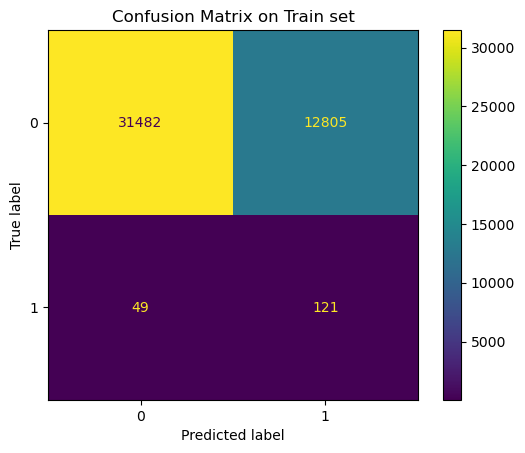

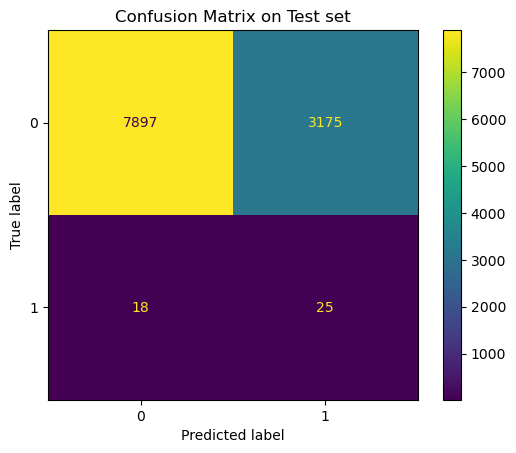

In [28]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline_clf, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(baseline_clf, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Beaucoup trop de faux positifs (precision = 0.01) : il faut réduire le nombre de 0 réels qui sont prédits 1 (3175)

### Model selection evaluation

On reprend les preprocessings du baseline model

#### Random Forest

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
categorical_transformer = OneHotEncoder(drop="first")
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [14]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [15]:
# Perform grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print("Grid search...")
classifier = RandomForestClassifier(class_weight='balanced')

# Grid of values to be tested
params = {
    "max_depth": [2, 5, 10, 15],
    "min_samples_leaf": [2, 5, 8],
    "min_samples_split": [2, 4, 8, 16],
    "n_estimators": [20, 50, 80],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=5, scoring='f1'
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation F1-score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 16, 'n_estimators': 50}
Best validation F1-score :  0.1250923544540566


In [19]:
y_train_pred = gridsearch.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44287
           1       0.89      0.99      0.94       170

    accuracy                           1.00     44457
   macro avg       0.95      1.00      0.97     44457
weighted avg       1.00      1.00      1.00     44457



In [23]:
y_test_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11072
           1       0.17      0.05      0.07        43

    accuracy                           1.00     11115
   macro avg       0.58      0.52      0.54     11115
weighted avg       0.99      1.00      0.99     11115



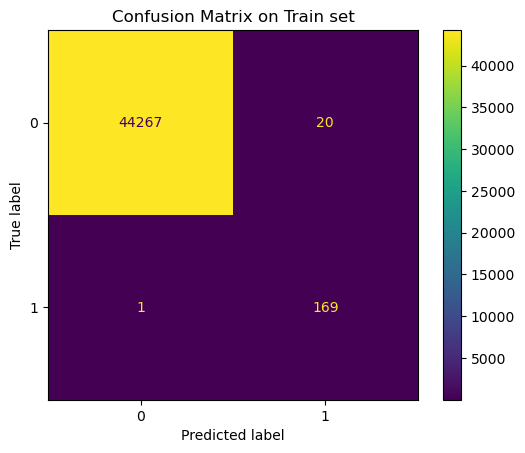

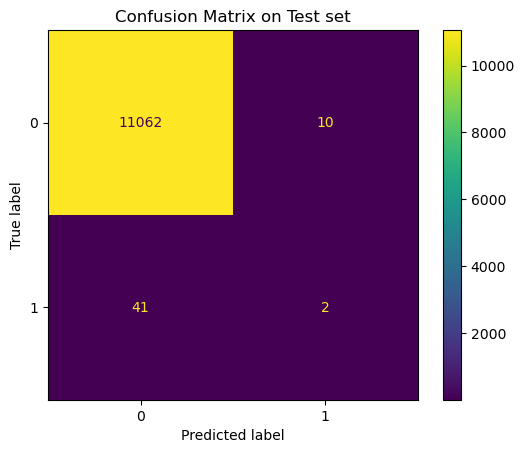

In [20]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

Il y a overfitting => on doit enlever des colonnes qui n'influent pas trop sur le résultat

In [21]:
column_names = []
for (
    name,
    step,
    features_list,
) in preprocessor.transformers_:  # loop over steps of ColumnTransformer
    if name == "num":  # if pipeline is for numeric variables
        features = (
            features_list  # just get the names of columns to which it has been applied
        )
    else:  # if pipeline is for categorical variables
        features = (
            step.get_feature_names_out()
        )  # get output columns names from OneHotEncoder
    column_names.extend(features)  # concatenate features names

# Create a pandas DataFrame
feature_importance = pd.DataFrame(
    index=column_names,
    data=gridsearch.best_estimator_.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")

# Plot coefficients
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, margin={"l": 120}  # to avoid cropping of column names
)
fig.show()

Pistes d'amélioration :
- Feature selection avec RFE
- Rééquilibrage des données non équilibrées (undersampling, oversampling)

#### Random Forest (avec un random undersampling)

In [ ]:
# Corriger : prendre un sample plus grand mais avec les mêmes proportions (frac = 0.5)
# Puis data cleanse
# Puis train test split
# Undersampling sur le train uniquement
# Fit Random Forest


In [26]:
data_non_frauds = data.loc[(data['is_fraud'] == 0),:].sample(2145, random_state=0)
data_frauds = data.loc[(data['is_fraud'] == 1),:]

data_sample_balanced = pd.concat([data_frauds, data_non_frauds], join='outer')
data_sample_balanced = data_sample_balanced.sample(frac=1)

df = data_cleanse(data_sample_balanced)

In [27]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'day', 'month', 'day_of_the_week', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']
features = categorical_features + numerical_features
target = 'is_fraud'

In [28]:
X = df.loc[:,features]
y = df.loc[:,target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
categorical_transformer = OneHotEncoder(drop="first")
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [29]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [30]:
# Perform grid search
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print("Grid search...")
classifier = RandomForestClassifier()

# Grid of values to be tested
params = {
    "max_depth": [2, 5, 10, 15],
    "min_samples_leaf": [2, 5, 8],
    "min_samples_split": [2, 4, 8, 16],
    "n_estimators": [20, 50, 80],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=5,
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80}
Best validation score :  0.8499407997759303


In [31]:
y_train_pred = gridsearch.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1716
           1       0.98      0.99      0.98      1716

    accuracy                           0.98      3432
   macro avg       0.98      0.98      0.98      3432
weighted avg       0.98      0.98      0.98      3432



In [34]:
y_test_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.81      0.84       429
           1       0.82      0.90      0.86       429

    accuracy                           0.85       858
   macro avg       0.85      0.85      0.85       858
weighted avg       0.85      0.85      0.85       858



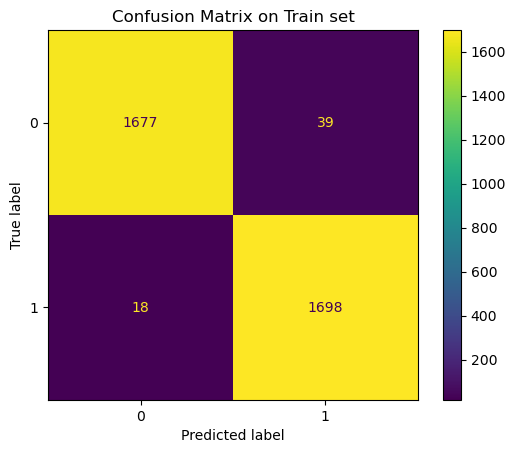

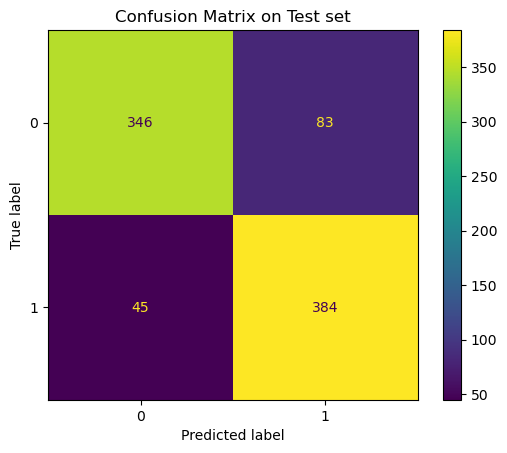

In [32]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [36]:
column_names = []
for (
    name,
    step,
    features_list,
) in preprocessor.transformers_:  # loop over steps of ColumnTransformer
    if name == "num":  # if pipeline is for numeric variables
        features = (
            features_list  # just get the names of columns to which it has been applied
        )
    else:  # if pipeline is for categorical variables
        features = (
            step.get_feature_names_out()
        )  # get output columns names from OneHotEncoder
    column_names.extend(features)  # concatenate features names

# Create a pandas DataFrame
feature_importance = pd.DataFrame(
    index=column_names,
    data=gridsearch.best_estimator_.feature_importances_,
    columns=["feature_importances"],
)
feature_importance = feature_importance.sort_values(by="feature_importances")

# Plot coefficients
fig = px.bar(feature_importance, orientation="h")
fig.update_layout(
    showlegend=False, margin={"l": 120}  # to avoid cropping of column names
)
fig.show()

#### Random Forest (avec SMOTE)

In [38]:
# Sample en conservant la proportion de is_fraud=0 et de is_fraud=1
data_sample_unbalanced = data.sample(frac=0.1, random_state=0)
print(data_sample_unbalanced['is_fraud'].value_counts())

df = data_cleanse(data_sample_unbalanced)

is_fraud
0    55359
1      213
Name: count, dtype: int64


In [39]:
categorical_features = ['category', 'gender']
numerical_features = ['age', 'day', 'month', 'day_of_the_week', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long']
features = categorical_features + numerical_features
target = 'is_fraud'

In [47]:
X.head()

,category,gender,age,day,month,day_of_the_week,city_pop,lat,long,merch_lat,merch_long
102051,grocery_pos,F,36,27,7,0,3285,40.8095,-72.8229,40.153684,-73.445235
270705,grocery_net,M,30,29,9,1,95,45.7549,-84.4470,46.699574,-84.995269
308877,home,M,44,16,10,4,1201,36.6704,-93.0377,36.439648,-92.203914
465523,misc_pos,M,54,12,12,5,23805,41.2403,-82.6078,41.901153,-83.097443
358267,shopping_pos,F,48,7,11,5,1766,30.5920,-97.2893,30.197385,-98.101702


In [56]:
X = df.loc[:,features]
y = df.loc[:,target]

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

#smote = SMOTE()
smotenc = SMOTENC(categorical_features=[0, 1])

X_smote, y_smote = smotenc.fit_resample(X_train, y_train)

categorical_transformer = OneHotEncoder(drop="first")
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

In [58]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [63]:
dict_weights = {0: 1, 1: 256}

In [86]:
print("Grid search...")
classifier = RandomForestClassifier(class_weight=dict_weights)

# Grid of values to be tested
params = {
    "max_depth": [5, 11, 15],
    "min_samples_leaf": [10, 12, 14],
    "min_samples_split": [2, 4, 6],
    "n_estimators": [20],
}
gridsearch = GridSearchCV(
    classifier, param_grid=params, cv=5, scoring='f1'
)  # cv : the number of folds to be used for CV
gridsearch.fit(X_train, y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation score : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 15, 'min_samples_leaf': 10, 'min_samples_split': 4, 'n_estimators': 20}
Best validation score :  0.1195360008805387


In [87]:
y_train_pred = gridsearch.predict(X_train)
print(classification_report(y_train, y_train_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44287
           1       0.71      0.92      0.81       170

    accuracy                           1.00     44457
   macro avg       0.86      0.96      0.90     44457
weighted avg       1.00      1.00      1.00     44457



In [88]:
y_test_pred = gridsearch.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11072
           1       0.12      0.07      0.09        43

    accuracy                           0.99     11115
   macro avg       0.56      0.53      0.54     11115
weighted avg       0.99      0.99      0.99     11115



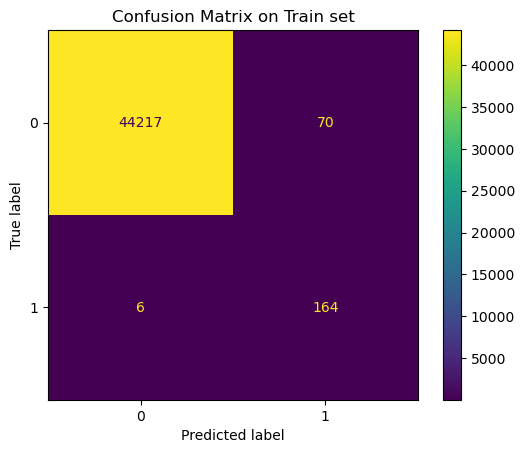

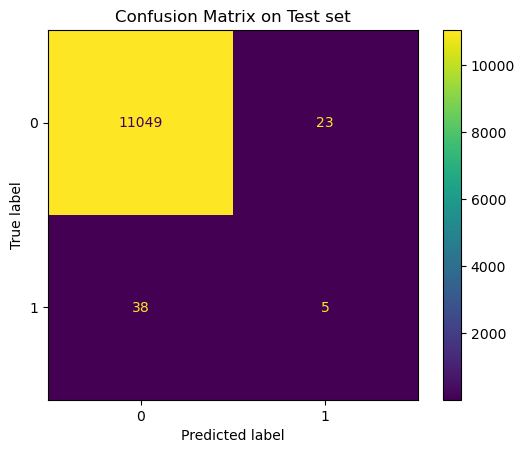

In [85]:
# Visualize confusion matrices
_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_train, y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch, X_test, y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

In [ ]:
# BalancedRandomForest ?